In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import ipywidgets as widgets
import sys, os, io, string, shutil, math
from hublib.ui import Submit
import hublib.use
%use boost-1.62.0-mpich2-1.3-gnu-4.7.2
import numpy as np
import re
import time
from threading import Thread
from io import StringIO
from ipywidgets import Layout, Box, Label, Output
from IPython.display import display

style = {'description_width': 'initial'}

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)

box_layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='100%',
    padding='5px'
)

<IPython.core.display.Javascript object>

In [2]:
e_np = widgets.BoundedFloatText(
    value=78.5,
    min=2,
    max=78.5,
    step=0.1,
    description='Dielectric const inside NP:',
    style=style,
)


In [3]:
e_out = widgets.BoundedFloatText(
    value=78.5,
    min=2,
    max=78.5,
    step=0.1,
    description='Dielectric const outside NP:',
    style=style,
)


In [4]:
pion = widgets.Dropdown(
    options={'1(monovalent)': 1, '2(divalent)': 2, '3(trivalent)': 3},
    value=1,
    description="Positive Ion Valency (z)",
    style=style
)


In [5]:
c_out = widgets.BoundedFloatText(
    value=0.0,
    min=0.0,
    max=0.4,
    step=0.1,
    description='salt concentration outside:',
    style=style
)


In [6]:
np_radius = widgets.BoundedFloatText(
    value=2.6775,
    min=2,
    max=5,
    step=0.001,
    description='Nanoparticle Radius (nm):',
    style=style
)


In [7]:
np_charge = widgets.BoundedFloatText(
    value=-60,
    min=-300,
    max=-30,
    step=-1,
    description='Nanoparticle Charge:',
    style=style
)


In [8]:
steps = widgets.BoundedIntText(
    value=10000,
    min=10000,
    max=5000000,
    step=100000,
    description='Simulation Steps:',
    style=style
)


In [9]:
label_style = "style='background-color: #81c4fd; font-size:500; padding: 2px'"
def make_label(name, desc=""):
    lval = '<p  %s %s>%s</p>' % (desc, label_style, name)
    return widgets.HTML(lval)

plabel = make_label('Physical Paramters', '')
clabel = make_label('Computing Paramters', '')

In [10]:
image_html = widgets.HTML(
    value='<img src="../webcontent/images/overview.jpg" style="width: 500px"/>',
)
image_html

HTML(value='<img src="../webcontent/images/overview.jpg" style="width: 500px"/>')

In [11]:
form_items = [
    Box([plabel], layout=form_item_layout),
    Box([e_np], layout=form_item_layout),
    Box([e_out], layout=form_item_layout),
    Box([c_out], layout=form_item_layout),
    Box([np_radius], layout=form_item_layout),
    Box([np_charge], layout=form_item_layout),
]

form = Box(form_items, layout=box_layout)
form

Box(children=(Box(children=(HTML(value="<p   style='background-color: #81c4fd; font-size:500; padding: 2px'>Physical Paramters</p>"),), layout=Layout(display='flex', flex_flow='row', justify_content='space-between', padding='5px')), Box(children=(BoundedFloatText(value=78.5, description='Dielectric const inside NP:', max=78.5, min=2.0, step=0.1, style=DescriptionStyle(description_width='initial')),), layout=Layout(display='flex', flex_flow='row', justify_content='space-between', padding='5px')), Box(children=(BoundedFloatText(value=78.5, description='Dielectric const outside NP:', max=78.5, min=2.0, step=0.1, style=DescriptionStyle(description_width='initial')),), layout=Layout(display='flex', flex_flow='row', justify_content='space-between', padding='5px')), Box(children=(BoundedFloatText(value=0.0, description='salt concentration outside:', max=0.4, step=0.1, style=DescriptionStyle(description_width='initial')),), layout=Layout(display='flex', flex_flow='row', justify_content='space-between', padding='5px')), Box(children=(BoundedFloatText(value=2.6775, description='Nanoparticle Radius (nm):', max=5.0, min=2.0, step=0.001, style=DescriptionStyle(description_width='initial')),), layout=Layout(display='flex', flex_flow='row', justify_content='space-between', padding='5px')), Box(children=(BoundedFloatText(value=-60.0, description='Nanoparticle Charge:', max=-30.0, min=-300.0, step=-1.0, style=DescriptionStyle(description_width='initial')),), layout=Layout(display='flex', flex_flow='row', justify_content='space-between', padding='5px'))), layout=Layout(align_items='stretch', border='solid 2px', display='flex', flex_flow='column', padding='5px', width='100%'))

In [12]:
form_items = [
    Box([clabel], layout=form_item_layout),
    Box([steps], layout=form_item_layout)
]

form = Box(form_items, layout=box_layout)
form


Box(children=(Box(children=(HTML(value="<p   style='background-color: #81c4fd; font-size:500; padding: 2px'>Computing Paramters</p>"),), layout=Layout(display='flex', flex_flow='row', justify_content='space-between', padding='5px')), Box(children=(BoundedIntText(value=10000, description='Simulation Steps:', max=5000000, min=10000, step=100000, style=DescriptionStyle(description_width='initial')),), layout=Layout(display='flex', flex_flow='row', justify_content='space-between', padding='5px'))), layout=Layout(align_items='stretch', border='solid 2px', display='flex', flex_flow='column', padding='5px', width='100%'))

In [13]:
about=widgets.Textarea(
    value='The Nanosphere Electrostatics Lab empowers users to simulate the self-assembly of ions near a spherically shaped nanoparticle, and extract the effective electrostatic properties. This information is necessary to understand nanoscale phenomena such as protein conformational changes, DNA precipitation, nanoparticle self-assembly, stability of emulsions, and charging/discharging processes in supercapacitor systems. This information helps guide the synthesis of materials in biomimetic nanocontainers and extraction of heavy metal ions from wastewater, and is useful to understand biological processes such as cell signaling and transport of ions across cell membrane.',
    placeholder='',
    layout={'height': '150px','width': '100%'},
    disabled=True,
    style = {'font_weight': '150px'}
)
about


Textarea(value='The Nanosphere Electrostatics Lab empowers users to simulate the self-assembly of ions near a spherically shaped nanoparticle, and extract the effective electrostatic properties. This information is necessary to understand nanoscale phenomena such as protein conformational changes, DNA precipitation, nanoparticle self-assembly, stability of emulsions, and charging/discharging processes in supercapacitor systems. This information helps guide the synthesis of materials in biomimetic nanocontainers and extraction of heavy metal ions from wastewater, and is useful to understand biological processes such as cell signaling and transport of ions across cell membrane.', disabled=True, layout=Layout(height='150px', width='100%'), placeholder='')

In [14]:
def clear_All():
    progressBar
    progressBar.value=int(0)
    plt.figure('Distribution of positive ions')
    plt.clf()  # clear old plot
    plt.figure('Energy Conservation of the Ionic System')
    plt.clf()  # clear old plot
    plt.figure('Ion Positions')
    plt.clf()  # clear old plot

In [15]:

runFlag=False
working_dir=""
parameter_append=""
sim_bigin=False

def callExe(s):
    global runFlag, working_dir, parameter_append, sim_bigin, ionsplot
    clear_All()
    
    e_np_value = e_np.value
    e_out_value = e_out.value
    pion_value = pion.value
    c_out_value = c_out.value
    np_radius_value = np_radius.value
    np_charge_value = np_charge.value
    sim_steps_value = steps.value
    walltime = 10
    total_processors = 1
    
    #Adding standard outputs to string to be sent to output widget callback function
    parameter_append= "Epsilon inside NP is"+ str(e_np_value)+"\n"
    parameter_append= parameter_append + "Epsilon outside NP is"+ str(e_out_value)+"\n"
    parameter_append= parameter_append + "Positive Ion Valency is"+ str(pion_value)+"\n"
    parameter_append= parameter_append + "Salt concentration outside is"+ str(c_out_value)+"\n"
    parameter_append= parameter_append + "Sphere(NP) radius is"+ str(np_radius_value)+"\n"
    parameter_append= parameter_append + "NP charge is"+ str(np_charge_value)+"\n"
    parameter_append= parameter_append + "simulation time step is"+ str(sim_steps_value)+"\n"
    parameter_append= parameter_append + "Requested walltime is "+ str(walltime)+"\n"
    parameter_append= parameter_append + "Requested total_processors are "+ str(total_processors)+"\n"
    
    shutil.rmtree('datafiles',True)
    if not os.path.exists('datafiles'):
        os.makedirs('datafiles')
    shutil.rmtree('outfiles',True)
    if not os.path.exists('outfiles'):
        os.makedirs('outfiles')
    shutil.rmtree('verifiles',True)
    if not os.path.exists('verifiles'):
        os.makedirs('verifiles')

    # forcing OpenMP thread size, comment when deploying
    os.environ["OMP_NUM_THREADS"] = "1"

    runName=''
    
    #computing parameters are scaled here.
    hiteqm_P =int(sim_steps_value * 0.1);
    writedata_U =int(sim_steps_value * 0.1);
    writedensity_W =int(sim_steps_value * 0.1);
    extra_compute_X = int(sim_steps_value * 0.01);
    moviefreq_F = int(sim_steps_value * 0.001);
    cpmd_verify_Y = int(sim_steps_value * 0.1); 
    
    #submit_str = '--local -p "@@Vin=%d:%d in %d" /apps/pegtut/current/examples/capacitor_voltage/sim1.py  --Vin=@@Vin' % (vin.value[0], vin.value[1], steps.value)
    
    paraList = ' -a ' + str(np_radius_value) + ' -b ' + str(14.28) + ' -e ' + str(e_np_value) + ' -E ' + str(e_out_value) \
    + ' -V ' + str(np_charge_value) + ' -v ' + str(pion_value) + ' -g ' + str(132) + ' -m ' + str(6) + ' -t ' \
    + str(0.001) + ' -s ' + str(10000) + ' -p ' + str(100) + ' -f ' + str(10) + ' -M ' + str(6) + ' -T ' \
    + str(0.001) + ' -k ' + str(0.0025) + ' -q ' + str(0.001) + ' -L ' + str(5) + ' -l ' + str(5) \
    + ' -S ' + str(sim_steps_value) + ' -P ' + str(hiteqm_P) + ' -F ' + str(moviefreq_F) \
    + ' -X ' + str(extra_compute_X) + ' -U ' + str(writedata_U) + ' -Y ' + str(cpmd_verify_Y) \
    + ' -W ' + str(writedensity_W) + ' -B ' + str(0.025) + ' -I ' + 'false'
    
    runFlag=True
    sim_bigin=True
    
    #starting a thread for on the fly density plot
    #t2 = Thread(target=iterative_density_plot)
    #t2.start()
    
    try:
        #rname = s.make_rname(e_np_value, e_out_value, pion_value, c_out_value, np_radius_value, np_charge_value, sim_steps_value)
         
        submit_str = '--local mpirun -np 1 ./np_electrostatics_lab' + paraList
        #submit_str = '--local pwd'
        s.run(runName, submit_str)
        
    except  Exception as e:
        sys.stderr.write('Error occured during the execution of np_electrostatics_lab')
        sys.stderr.write(str(e))
        sys.exit(1)
    
    time.sleep(1)
    runFlag = False
    ionsplot = True
    #t2.join()
        
    
        
  

In [16]:
# after the run finished, optionally do something
# with the output
def plot_data(s, rdir):
    #We ignore rdir because submit puts non-parametric runs in the current directory
    # When caching is enabled, they get put in a chached directory and rdit is always used. 
    #wait for 2 seconds before plotting errorBars.
    time.sleep(2)
    progressBar.value=int(100)
    plt.figure('Distribution of positive ions')
    plt.clf()  # clear old plot
    plt.title('Final distribution of positive ions near the nanoparticle surface')
    plt.xlabel('Distance from the center of the nanoparticle (R = 0 is the midpoint)(nm)', fontsize=10)
    plt.ylabel('Density(M)', fontsize=10)
    
    # our simulation writes to outfiles -> density_profile.dat
    try:
        density_profile = np.loadtxt(working_dir + 'outfiles/density_profile.dat')
    except:
        sys.stderr.write('Can not find the positive density results file')
        sys.exit(1)
    print(density_profile)    
    x = density_profile[:,0]
    y = density_profile[:,1]
    yrr = density_profile[:,2]
    plt.errorbar(x,y,xerr=0.0, yerr=yrr, c='b', ecolor='r', capsize=2)
    
    plt.show()

In [17]:
def density_plot_with_string(timeStep, plotdata):
    plt.figure('Distribution of positive ions')
    plt.clf()  # clear old plot
    plt.title(" Ionic distribution near the nanoparticle surface at time step = " + str(timeStep))
    plt.xlabel('Distance from the center of the nanoparticle (R = 0 is the midpoint)(nm)', fontsize=10)
    plt.ylabel('Density(M)', fontsize=10)
    
    content = StringIO(plotdata)
    density_profile = np.loadtxt(content, delimiter=',')
    
    x = density_profile[:,0]
    y = density_profile[:,1]
  
    plt.plot(x,y,'b-')
    plt.show()

In [18]:
def energy_plot_with_string(plotdata):
    plt.figure('Energy Conservation of the Ionic System')
    plt.clf()  # clear old plot
    plt.title("Energy profiles for the simulation")
    plt.xlabel('Simulation Time Steps', fontsize=10)
    plt.ylabel('Energy(KBT)', fontsize=10)
    
    content = StringIO(plotdata)
    energy_profile = np.loadtxt(content, delimiter=',')
    #print(energy_profile)
    
    step = energy_profile[:,0]
    extended = energy_profile[:,1]
    kinetic_physical = energy_profile[:,2]
    potential = energy_profile[:,3]
    kinetic_virtual = energy_profile[:,4]
    
    plt.plot(step,extended, color='red', label='Extended')
    plt.plot(step,kinetic_physical, color='green', label='Kinetic (physical)')
    plt.plot(step,potential, color='blue', label='Potential')
    plt.plot(step,kinetic_virtual, color='yellow', label='Kinetic (virtual)')
    plt.legend()
    plt.show()

In [19]:
ionsplot = True

def ions_plot_with_string(plotdata):
    global ionsplot, ax_ions, scatter_ion
    
    content = StringIO(plotdata)
    pos_data = np.loadtxt(content, delimiter=',')
    #print(pos_data)
    
    index = pos_data[:,0]
    valency = pos_data[:,1]
    xx = pos_data[:,2]
    yy = pos_data[:,3]
    zz = pos_data[:,4]
    
    ionsfig = plt.figure('Ion Positions')
    
    if ionsplot:
        plt.clf()  # clear old plot
        ax_ions = ionsfig.add_subplot(111, projection='3d')
        '''
        #Adding a sphere in the middle
        # Make data
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = 5 * np.outer(np.cos(u), np.sin(v))
        y = 5 * np.outer(np.sin(u), np.sin(v))
        z = 5 * np.outer(np.ones(np.size(u)), np.cos(v))
        # Plot the surface for the sphere
        ax_ions.plot_surface(x, y, z, color='b')
        plt.show()
        '''
        #plot NP
        ax_ions.scatter(0, 0, 0, c='b', s=100, marker='o')
        #plot points for the 1st time
        scatter_ion = ax_ions.scatter(xx, yy, zz, c='r', marker='o')
        ax_ions.set_xlabel('X(nm)')
        ax_ions.set_ylabel('Y(nm)')
        ax_ions.set_zlabel('Z(nm)')
        plt.show()
        ionsplot = False
    else:
        scatter_ion.remove()
        scatter_ion = ax_ions.scatter(xx, yy, zz, c='r', marker='o')
        #ax_ions._offsets3d = (xx, yy, zz)
        plt.draw()
 
    
    
    

In [20]:
in_wrapper_density = False
in_wrapper_energy = False
in_wrapper_ions_pos = False
saved_data = ""
saved_data_enery = ""
saved_data_ions_pos = ""
stepNumber = 0
def stdoutput_handler(buffer):
    global in_wrapper_density, saved_data, parameter_append, sim_bigin, stepNumber, in_wrapper_energy, saved_data_enery, saved_data_ions_pos, in_wrapper_ions_pos
    output = []
    
    if sim_bigin:
        output.append(parameter_append)
        sim_bigin = False
   
    data = buffer.split('\n')
    last = len(data) - 1
    
    for i, line in enumerate(data):
        if in_wrapper_density:
            if line.startswith('####_Density_Profile_Wrapper_Over_#'):
                #print(stepNumber)
                #print(saved_data)
                density_plot_with_string(stepNumber, saved_data)
                in_wrapper_density = False
            else:
                saved_data += line
                if line == '' or (i != last):
                    saved_data += '\n'
            continue
        elif in_wrapper_energy:
            if line.startswith('####_Energy_Profile_Wrapper_Over_####'):
                energy_plot_with_string(saved_data_enery)
                in_wrapper_energy = False
            else:
                saved_data_enery += line
                if line == '' or (i != last):
                    saved_data_enery += '\n'
            continue
        elif in_wrapper_ions_pos:
            if line.startswith('####_Ions_Position_Wrapper__Over_####'):
                ions_plot_with_string(saved_data_ions_pos)
                in_wrapper_ions_pos = False
            else:
                saved_data_ions_pos += line
                if line == '' or (i != last):
                    saved_data_ions_pos += '\n'
            continue 
        if line.startswith('=PROGRESS=>'):
            percent = (line.split('=PROGRESS=>'))[1]
            progressBar.value=int(percent)
        elif line.startswith('####_Density_Profile_Wrapper_#####'):
            stepNumber = int(line.split('####_Density_Profile_Wrapper_#####Stepsize:')[1])
            in_wrapper_density = True
            saved_data = ""
        elif line.startswith('####_Energy_Profile_Wrapper_####'):
            in_wrapper_energy = True
            saved_data_enery = ""
        elif line.startswith('####_Ions_Position_Wrapper_####'):
            in_wrapper_ions_pos = True
            saved_data_ions_pos = ""
        else:
            if line:
                output.append(line)

    return '\n'.join(output)

<IPython.core.display.Javascript object>


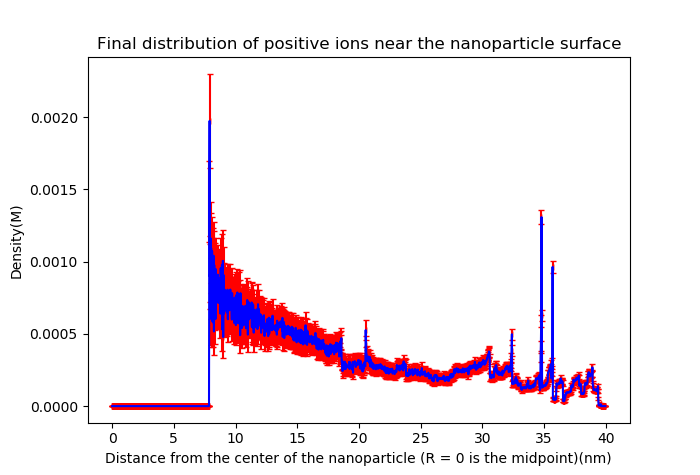

<IPython.core.display.Javascript object>


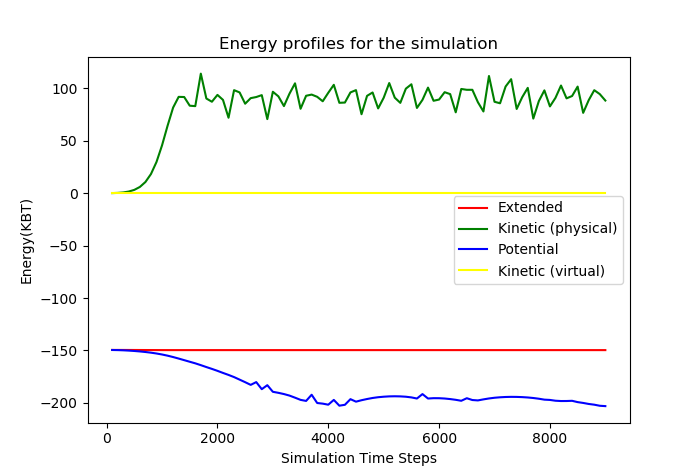

<IPython.core.display.Javascript object>


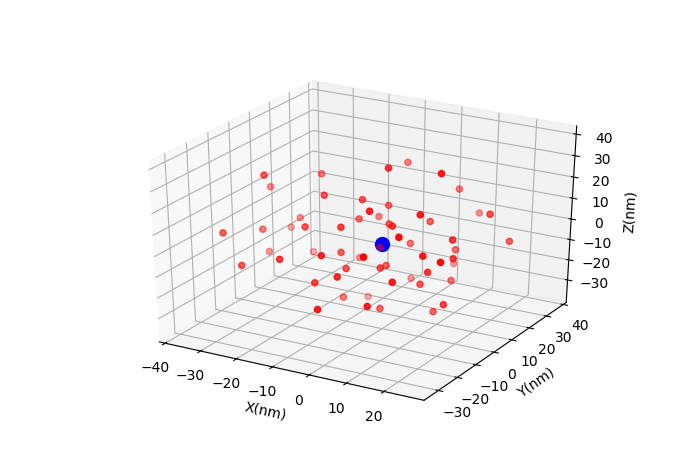

In [21]:
tab_layout=Layout(
    width='100%',
    height='100%'
)

# we want the plot to go here, so create an empty one initially
#create tabs
figsize_tup=(7, 4.75)
figure_density = plt.figure(num='Distribution of positive ions', figsize=figsize_tup)
out_desnity = Output(layout=tab_layout)

figure_energy = plt.figure(num='Energy Conservation of the Ionic System', figsize=figsize_tup)
out_energy = Output(layout=tab_layout)

figure_ions = plt.figure(num='Ion Positions', figsize=figsize_tup)
out_ion = Output(layout=tab_layout)


In [22]:
#tab_contents = ['Density Profile', 'Energy Conservation', 'Ion Distribution']
tab_contents = ['Density Profile', 'Energy Conservation']
#children = [out_desnity, out_energy, out_ion]
children = [out_desnity, out_energy]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, str(tab_contents[i]))
tab.selected_index = 0
tab

Tab(children=(Output(layout=Layout(height='100%', width='100%')), Output(layout=Layout(height='100%', width='100%'))), _titles={'0': 'Density Profile', '1': 'Energy Conservation'})

In [23]:
with out_desnity:
    display(figure_density, layout=tab_layout)
with out_energy:
    display(figure_energy)
with out_ion:
    display(figure_ions)

In [24]:
#Submit(start_func=callExe, done_func=plot_data, cachename='SubmitTest1')
Submit(start_func=callExe, done_func=plot_data, outcb=stdoutput_handler)


VBox(children=(Button(button_style='success', description='Run', style=ButtonStyle(), tooltip='Run Simulation'),), layout=Layout(flex_flow='column', justify_content='flex-start', width='auto'))

In [25]:
progressBar=widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Progress:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal',
    layout={'width': '100%'},
)
progressBar

IntProgress(value=0, description='Progress:', layout=Layout(width='100%'))